# Notebook 2: Rating Curve Development

In [3]:
import math
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, Band
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
output_notebook()

import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


Loading BokehJS ...

## Introduction

It isn't typically possible to accurately measure surface runoff directly on a *continuous* basis.  Instead, in practice it is much easier and more reliable to install an instrument in the river to measure pressure, which recall is a linear function of the depth of water.  A hydrometric station is often simply a pressure transducer (below) connected to a device to store measurements in memory (such as a data logger).  We then need a way to map these recorded water depth measurements -- referred to as 'stage' measurements -- to **volumetric flow**, i.e. ($\frac{m^3}{s}$).

![Pressure Transducer](img/transducer.png)


![Hydrometric Station](img/station.png)

In the last exercise, we processed a single discharge measurement taken using the salt dilution method.  Typically we want to collect discharge measurements to describe as much of the expected range of natural flow conditions as possible, from very low flows in the dry season, to the highest flows we can (safely) measure.

**Note**: A folder of references is provided containing governing standards for hydrometric data collection, as well as a discussion paper on uncertainty in hydrometric data collection.

Go through this notebook and follow along with the development of the stage-discharge rating curve. At the end, there is an open ended question that requires you to reflect on the content of the notebook. Written responses are to be submitted via Canvas, where a response field will be set up.

## Stage-Discharge (Rating Curve) Development

The purpose of establishing continuous collection of stage data, and collecting many discharge (flow) measurements is to establish (and validate) a relationship between the water level and the volumetric flow over a wide range of conditions:

![Stage-Discharge Relationship (source: Hamilton & Moore (2012))](img/rating_curve_ex.png)

Each point in the above plot represents an 'instantaneous' discharge measurement, and the water level (stage) at the time the discharge measurement was taken.

In this exercise, we will develop a stage-discharge relationship from a collection of discharge measurements and the corresponding stage record. Once a valid stage-discharge relationship has been established, it can be used to translate the time series of **stage measurements** to a time series of **discharge measurements**.

## Import the Data

In [4]:
# import the stage data
stage_df = pd.read_csv('../../Project_Data/Hidden_Creek_stage_data.csv', parse_dates=['Date'])
# stage_df.dropna(inplace=True)
stage_df.loc[:, 'Value'] = pd.to_numeric(stage_df.loc[:, 'Value'], errors='coerce')

In [5]:
# take a quick look at what we're dealing with
stage_df

,ID,PARAM,Date,year,month,day,Value
0,00XX000,2,2010-08-25,2010,8,25,0.830
1,00XX000,2,2010-08-26,2010,8,26,0.876
2,00XX000,2,2010-08-27,2010,8,27,1.160
3,00XX000,2,2010-08-28,2010,8,28,0.867
4,00XX000,2,2010-08-29,2010,8,29,0.711
...,...,...,...,...,...,...,...
672,00XX000,2,2012-06-27,2012,6,27,1.950
673,00XX000,2,2012-06-28,2012,6,28,2.000
674,00XX000,2,2012-06-29,2012,6,29,2.380
675,00XX000,2,2012-06-30,2012,6,30,2.710


In [6]:
# looking at the data preview above, the water level (stage) label is quite long
stage_label = 'Value'

stage_df = stage_df[['Date', 'Value']].copy()

# let's shorten it by renaming the column
# We want a name to be descriptive, and it should also contain the units
# note the Date column is unchanged, but needs to be included in the 
# order the columns appear from left to right
stage_df.columns = ['Date', 'WL_m']

In [7]:
# import the table of discrete discharge measurements
rc_df = pd.read_csv('../../Project_Data/Project_QH_table_2021.csv', parse_dates=['Date'])

In [8]:
# take a look at the discharge measurements
rc_df.head(15)

,Date,Flow (m^3/s),water level (m above 0 flow ref)
0,2010-12-24,4.340,1.130
1,2011-01-11,0.217,0.149
2,2011-05-04,3.470,1.020
3,2011-09-19,4.280,0.966
4,2011-10-24,4.510,1.070
5,2011-12-17,0.997,0.443
6,2012-01-26,2.480,0.648
7,2012-02-18,1.330,0.624
8,2012-02-24,1.540,0.516


## Plot the Data

### Plot Measured Discharge and corresponding stage (water level)

From previous site visits, we have collected a total of 9 discharge measurements as can be seen in the `rc_df` dataframe above.  During each measurement, we manually measure the water level to validate the data being recorded continuously by our pressure transducer and datalogger (hydrometric station).  We validate the pressure transducer reading because instrument calibration is not perfect, and can change over time for a number of reasons.  It is important to measure stage by some independent means before and after a discharge measurement in order to to assess the quality of the stage-discharge relationship and any analysis derived from it.  Validating the hydrometric station stage concurrent to a discharge measurement is typically done manually, such as with a benchmark survey.


<AxesSubplot:xlabel='Flow (m^3/s)'>

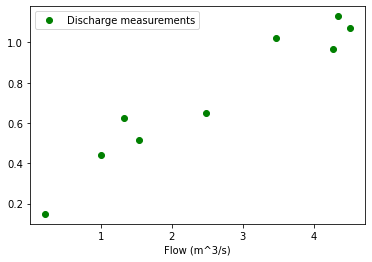

In [9]:
# plot the discharge measurements on the x-axis, and the corresponding stage on the y axis
q_measured = 'Flow (m^3/s)'
wl_measured = 'water level (m above 0 flow ref)'
rc_df.plot(q_measured, wl_measured, 
           marker='o', color='g',
           linestyle='',
           label='Discharge measurements')

### Add the new discharge measurement

In Notebook 1, we processed a discharge measurement using salt dilution.  Let's update our rating curve with this latest data point.

### Find the stage on the measurement date (26 September 2010)

Instead of manually looking up what the water level was on a particular date, we can use an indexing method to directly return the value at the time of interest./

In [10]:
# measurement_date
msmt_date = '2010-09-20'
 
# here, we are indexing the stage dataframe to return 
# just the row corresponding to the date we're interested in
msmt_date_data = stage_df[stage_df['Date'] == pd.to_datetime(msmt_date)].copy()

# now just extract the stage
# and round to 3 decimals
msmt_date_data.loc[:, 'WL_m'] = pd.to_numeric(msmt_date_data.loc[:, 'WL_m'])
msmt_stage = msmt_date_data['WL_m'].round(3)

# Note that when we index this way,  
# a dataframe is still returned
print(msmt_stage)
print('------')
print('')

# To get just the value
msmt_stage = msmt_stage.values[0]
print('The stage on {} was {} m.'.format(msmt_date, msmt_stage))

26    2.74
Name: WL_m, dtype: float64
------

The stage on 2010-09-20 was 2.74 m.


In [11]:
test = stage_df.set_index('Date')
test[test.index == '2010-09-10']

,WL_m
Date,
2010-09-10,0.626


### Add Latest Data

In Notebook 1, we calculated discharge using the salt dilution method.  Include this new measurement and see how it compares to the rest of the measurements.

In [12]:
# add a new point - get the discharge value 
# you calculated in the previous tutorial
# Here we can enter the additional point for the rating curve 
# from the salt dilution measurement calculation exercise
# set variables corresponding to the discharge and stage from that measurement

Q_calculated = 12 # enter the value you calculated from Tutorial 1
concurrent_stage = msmt_stage # we determined msmst_stage in the previous cell

# Add the newly measured point to the rating curve (discharge data) dataframe
# len(stage_df) + 1 makes it add a row at the bottom
rc_df.loc[len(rc_df)] = [pd.to_datetime(msmt_date), Q_calculated, msmt_stage]
rc_df.loc[len(rc_df)] = [pd.to_datetime(msmt_date), 5, 0.36]

# print out the updated dataframe and see the new point added
rc_df

,Date,Flow (m^3/s),water level (m above 0 flow ref)
0,2010-12-24,4.340,1.130
1,2011-01-11,0.217,0.149
2,2011-05-04,3.470,1.020
3,2011-09-19,4.280,0.966
4,2011-10-24,4.510,1.070
5,2011-12-17,0.997,0.443
6,2012-01-26,2.480,0.648
7,2012-02-18,1.330,0.624
8,2012-02-24,1.540,0.516
9,2010-09-20,12.000,2.740


### Plot the stage-discharge measurement points and the rating curve

The plot below is where you will be able to validate if your answer for question 4 is correct.

### Plot a Curve Representing the Standard Stage-Discharge Relationship

The standard stage-discharge relationship takes the form $Q = C(h-h_0)^b$ where:

* Q = flow $[\frac {m^3}{s}]$
* C = rating coefficient $[-]$
* $h_0$ = elevation offset $[m]$ corresponding to the point of zero flow
* b = hydraulic control shape coefficient $[-]$

The rating exponent (b) is related to some extent to the cross sectional shape of the hydraulic control.  Values for the rating exponent suggested by Environment Canada (2012) are as follows:

| Shape | Value of exponent (b) |
|---|---|
| Rectangular | 1.3 to 1.8 |
| Parabolic | 1.7 to 2.3 |
| Triangular | 2.5 to 3 |


In [13]:
# definition of rating curve: calculate Q from h, given the parameters.
def calc_q(C, h, h0, b):
    """
    Standard form of the rating curve equation.
        Q = flow [m^3/s]
        C = rating coefficient [-]
        h0 = elevation offset [m] - corresponds to point of zero flow
        b = hydraulic control shape coefficient [-]
    Return volumetric flow [m^3/s]
    """
    return C*(h-h0)**b

Below are rating curve parameters (`h0`, `b`, `C`) that are purposely not a great fit to the discharge data.  

Try changing the values to see the effect on how the curve fits the measured discharge data.

In [14]:
h0 = -0.1   # offset parameter
b = 1.8      # exponent (shape) parameter
C = 8.0      # coefficient parameter

# here, set a range of stage values over which
# we will calculate discharge based on our rating curve parameters
stage_min = 0.001
stage_max = 1.5
stage_nr_steps = 110
stage_range = np.linspace(stage_min, stage_max, stage_nr_steps)

# here we calculate flow (q) for every value of stage
# we defined in stage_range above
manual_fit_q = [calc_q(C, h, h0, b) for h in stage_range]

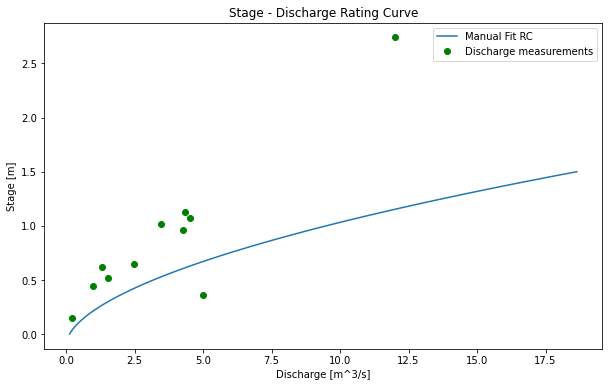

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(manual_fit_q, stage_range, label='Manual Fit RC')
ax.plot(rc_df[q_measured].to_numpy(), rc_df[wl_measured].to_numpy(), 
           marker='o', color='g',
           linestyle='',
           label='Discharge measurements')
ax.set_title('Stage - Discharge Rating Curve')
ax.set_xlabel('Discharge [m^3/s]')
ax.set_ylabel('Stage [m]')
ax.legend()
plt.show()

## Curve Fitting Method

Above, we plotted the stage-discharge curve using made up parameters for C, h0, and b.  We can use a "guess-and-check" method to change the parameters until they have a 'good' visual fit, but let's be more efficient and systematic and use a "best fit" method.

Because our equation is not linear (normally $b \neq 1$), we can't use the linear best fit function shown in Tutorial 1.  Or can we?

Recall the rating curve equation from above is: $Q = C(H-h_0)^b$.  

If we transform the data to a log-log space, taking the logarithm of both axes, we get the following: $log(Q) = log(C) + b\cdot log(h-h_0)$

We can then rearrange the terms to match the linear form: $y = slope \cdot x + intercept$.

Recall the x and y axis parameters are discharge (Q) and water level (h), respectively, so the linear form of the equation is then: 

$$log(h-h_0) = slope \cdot log(Q) + intercept$$

Using this linear form of the equation, we can use the ordinary least squares (OLS) method to find the slope and intercept corresponding to the best fit line (in log-log space).  The last step is to transform the values back to linear space.

Note that $h_0$ cannot be fitted this way, and has to be set manually. In this case we start by assuming $h_0=0$.

In [16]:
print(rc_df)

         Date  Flow (m^3/s)  water level (m above 0 flow ref)
0  2010-12-24         4.340                             1.130
1  2011-01-11         0.217                             0.149
2  2011-05-04         3.470                             1.020
3  2011-09-19         4.280                             0.966
4  2011-10-24         4.510                             1.070
5  2011-12-17         0.997                             0.443
6  2012-01-26         2.480                             0.648
7  2012-02-18         1.330                             0.624
8  2012-02-24         1.540                             0.516
9  2010-09-20        12.000                             2.740
10 2010-09-20         5.000                             0.360


In [17]:
# Find the best-fit line in log-log space
# set our stage offset to zero
h0 = 0
# take the logarithm of the measured streamflows and the stage
q_log = np.log(rc_df['Flow (m^3/s)'] - h0)
stage_log = np.log(rc_df['water level (m above 0 flow ref)'])

# find the slope and intercept parameters describing the linear best fit using ordinary least squares (OLS)
log_slope, log_intercept, log_rval, log_pval, log_stderr = st.linregress(q_log, stage_log)

The linearized form of the best fit equation was shown in the last step: $log(h-h_0) = slope \cdot log(Q) + intercept$.

The `st.linregress` function solved the ordinary least squares best fit and yielded the `slope` and `intercept` of the best fit line, so we have two unknowns.  When we plotted the general stage-discharge curve above, we set a variable `stage_range` to evaluate the range of water level over which we're interested in knowing the corresponding flow.  The remaining unknown is then the `log(Q)` term, but we want a function that will give us the discharge (`Q`) in linear space.  

### Solve for Q

The last step is to rearrange the log form of the equation we derived previously ($log(h-h_0) = slope \cdot log(Q) + intercept$) in order to solve for flow (`Q`).  

In [18]:
# calculate the discharge based on the best fit
# parameters found by ordinary least squares above
def ols_rc_q(slope, intercept, h, h0):
    """
    Calculate flow (Q) from the linear best fit parameters.
        -slope: the `log_slope` calculated above (constant)
        -intercept: `log_intercept` calculated above (constant)
        -h0 is the same PZF offset used above (constant)
        -h is the independent variable
    Returns Q, the discharge in m^3/s.
    """
    if slope == 0:
        return 0
    try:
        return np.exp((np.log(h - h0) - intercept) / slope)
    except ValueError: 
        return None

In [19]:
# put best fit results into a dataframe for plotting
# use 0 as the PZF (point of zero flow) (the h0 parameter)
bf_df = pd.DataFrame()
bf_df['stage'] = stage_range

# now as before, apply the `ols_rc_q` function to create the stage-discharge
# curve based on the best-fit equation
bf_df['best_fit_q'] = [ols_rc_q(log_slope, log_intercept, h, 0) for h in stage_range]
bf_df.sort_values(by='stage', inplace=True)

# now add the manual fit we developed above -- this way we can compare the two curves side-by-side
bf_df['manual_fit_q'] = manual_fit_q

### Plot the best fit curve


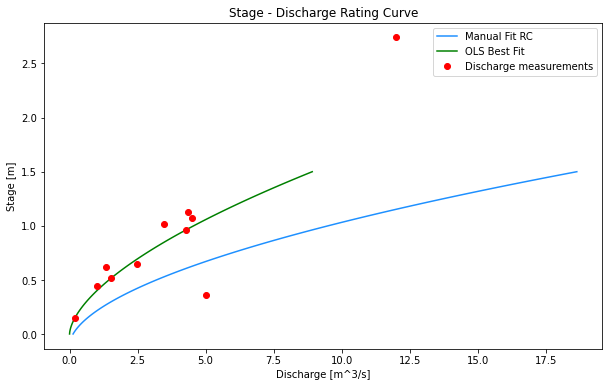

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(manual_fit_q, stage_range, color='dodgerblue', label='Manual Fit RC')
ax.plot(bf_df['best_fit_q'].to_numpy(), bf_df['stage'].to_numpy(),
        color='green', label="OLS Best Fit")

ax.plot(rc_df[q_measured].to_numpy(), rc_df[wl_measured].to_numpy(), 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

ax.set_title('Stage - Discharge Rating Curve')
ax.set_xlabel('Discharge [m^3/s]')
ax.set_ylabel('Stage [m]')
ax.legend()
plt.show()

In [21]:
# if you want to export this data to continue working in excel (or another program)
# You can call a function to write a dataframe directly to csv using the command below.
# The string is the filename, and you can additionally add path information
# just remove the '#' symbol at the start of the line below and execute this cell by pressing shift + enter, or by hitting the 'play' button at the top
# bf_df.to_csv('rating_curve_data.csv')

### Plot the Daily Average Hydrograph From the Rating Curve 

Now that we've established the relationship between stage and discharge, we can transform the continuous stage record into a continuous flow record.

Apply the rating curve equation we developed above to the long-term water level (stage) time series from our hydrometric station.  Add the result as a new column in the `stage_df` dataframe.  Note the distinction between the stage measured during the discrete measurements, and the "continuous" stage (water level) recorded by our pressure transducer.  It is the pressure-transducer series we want to apply the rating curve equation to, not the water level from the discharge measurements!

In [22]:
# calculate a dicharge based on the best fit or manually fit rating curve
# for each water level recorded in the measured stage record (stage_df)

stage_df.loc[:, 'RC Q (cms)'] = stage_df['WL_m'].apply(lambda h: ols_rc_q(log_slope, log_intercept, h, 0))

# add in the parameters we set manually
stage_df.loc[:, 'Manual Q (cms)'] = stage_df['WL_m'].apply(lambda h: calc_q(C, h, h0, b))


In [23]:
stage_df

,Date,WL_m,RC Q (cms),Manual Q (cms)
0,2010-08-25,0.830,3.348681,5.720455
1,2010-08-26,0.876,3.661432,6.303727
2,2010-08-27,1.160,5.828026,10.449954
3,2010-08-28,0.867,3.599373,6.187630
4,2010-08-29,0.711,2.591931,4.329675
...,...,...,...,...
672,2012-06-27,1.950,13.769525,26.616582
673,2012-06-28,2.000,14.358850,27.857618
674,2012-06-29,2.380,19.150173,38.100310
675,2012-06-30,2.710,23.742096,48.132089


In [24]:
# again, if you want to export this dataframe to csv for use in Excel
# or other program, use the command below
# stage_df.to_csv('derived_flow_series.csv')

### Plot the Resulting Flow series and the rating curve

The two plots below are linked.  Check the selection tools, and select points on one plot.  When validating data, it is helpful to be able to link the measurements on the rating curve plot and the daily flow series plot.  Consider how you would you check if the low flows were subject to a shift in the hydraulic control over time?    

In [25]:
print(stage_df.columns)
print(rc_df.columns)

Index(['Date', 'WL_m', 'RC Q (cms)', 'Manual Q (cms)'], dtype='object')
Index(['Date', 'Flow (m^3/s)', 'water level (m above 0 flow ref)'], dtype='object')


In [26]:
# output to static HTML file
#output_file("filename.html")

# customize the tools for interacting with the bokeh plot
TOOLS="pan,wheel_zoom,reset,hover,poly_select,box_select"

# Bokeh uses a ColumnDataSource data structure to 
# link plots and make them more interactive

stage_df = stage_df.reset_index(drop=True)

# set data sources for plot linking
rc_source = ColumnDataSource(data=dict())
rc_source.data = rc_source.from_df(rc_df)

ts_source = ColumnDataSource(data=dict())
ts_source.data = ts_source.from_df(stage_df)

#### RATING CURVE PLOT (LET)
rc_plot = figure(plot_width=550, plot_height=400,
                title='Rating Curve Plot',
                tools=TOOLS)

# plot the measured discharge points
rc_plot.circle('Flow (m^3/s)', 'water level (m above 0 flow ref)', size=5, color="red", alpha=0.5,
              legend_label='Measured Q', source=rc_source)

# plot the rating curve based on the manual rating curve fit
rc_plot.line(manual_fit_q, stage_range, line_color='dodgerblue',
             legend_label='Manual Fit')

# plot the rating curve based on the OLS best fit
rc_plot.line(bf_df['best_fit_q'], bf_df['stage'],
             line_color='green', legend_label='OLS Fit')

#### DAILY FLOW SERIES PLOT (RIGHT)
daily_flow_plot = figure(plot_width=550, plot_height=400, 
                        x_axis_type='datetime', title='Daily Flow Hydrograph')

# # plot the flow series based on the OLS best fit
daily_flow_plot.line('Date', 'RC Q (cms)', 
                    legend_label='OLS-based RC Flow', color='green',
                    source=ts_source)

# plot the flow series based on the manual fit
daily_flow_plot.line('Date', 'Manual Q (cms)', 
                    legend_label='Manual RC Flow', color='dodgerblue',
                    source=ts_source)

# plot the daily flow series generated from the manual rating curve
daily_flow_plot.circle('Date', 'Flow (m^3/s)', size=5, color="red", alpha=0.8,
              source=rc_source, legend_label='Measured Q')

# daily_flow_plot.line('Date', 'RC Q (cms)')
# label the axes
daily_flow_plot.xaxis.axis_label = 'Date'
daily_flow_plot.yaxis.axis_label = 'Flow (m³/s)'
daily_flow_plot.legend.location = "top_left"
rc_plot.xaxis.axis_label = 'Flow (m³/s)'
rc_plot.yaxis.axis_label = 'Stage (m)'
rc_plot.legend.location = "bottom_right"

layout = gridplot([[rc_plot, daily_flow_plot]])

# show the results
show(layout)

## Summary and Reflection

In this notebook we have used discrete measurements to develop a relationship between water level and volumetric flow.  We've used this relationship to develop what is commonly called a 'measured flow series' (the plot above at right), but it's really just an estimate of a relationship that changes in time due to natural morphological processes.  As we saw in Notebook 1 there is uncertainty in the measurements themselves, and in this notebook we see there is uncertainty in the stage-discharge relationship.

It is typical that the hydrometric station will record a greater range of water level than what is captured during site visits when discrete discharge measurements are taken.  This is because the hydrometric station is installed and left running to measure water level 'continuously' (at some frequency, such as 2 minutes or 15 minutes) for years at a time.  In many cases it isn't practical or cost effective to make more than three or four visits per year to the station to collect measurements, download stage data, check datalogger batteries, etc.  As a result, it is typical to have discrete discharge measurements over a narrower range of flow conditions than is measured by the hydrometric station, so our 'measured flow series' then must *extrapolate* from the range of conditions we have actually taken discrete measurements for.  

The 'measured flow series' is used in many applications in resource engineering.  Low flows are used to determine natural or baseline conditions for fish habitat impact assessments, high flows are used to size hydraulic structures, such as dam spillways.  Hydrometric stations are often installed in new locations to support projects that have multi-decade planning horizons.  

## Questions for Reflection

Ultimately, the rating curve and measured discharge series are used to characterize a water resource to support decisions in policy and design.  In characterizing a water resource, not only is it common to extrapolate beyond the range of measured conditions, it is necessary to extrapolate into the future.  

Provide a brief discussion (1-2 paragraphs) describing how your confidence in the flow predicted by the rating curve changes as a function of water level?  Compare your level of confidence in the rating curve accurately predicting flow tomorrow, versus one year from now, versus ten years from now.  How might these concerns be addressed?  